# Jargon Terminoly Detection using Conditional Random Forest

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install sklearn-crfsuite

In [3]:
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats
import eli5

2023-04-18 22:01:44.488755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 22:01:45.037975: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 22:01:45.146145: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-18 22:01:45.146205: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [5]:
df_val = pd.read_csv('/kaggle/input/jargon-detection/validation.csv')
df_val.head(5)

,token_id,token,label
0,cs/doc_1867/0/0,Section,O
1,cs/doc_1867/0/1,~,O
2,cs/doc_1867/0/2,illustrates,O
3,cs/doc_1867/0/3,the,O
4,cs/doc_1867/0/4,proposed,O


In [6]:
df_train = pd.read_csv('/kaggle/input/jargon-detection/train.csv')
df_train.head(5)

,token_id,token,label
0,cs/doc_1/0/0,A,O
1,cs/doc_1/0/1,SHAP,O
2,cs/doc_1/0/2,summary,O
3,cs/doc_1/0/3,plot,TERM
4,cs/doc_1/0/4,shows,O


In [7]:
df_test = pd.read_csv('/kaggle/input/jargon-detection/test_no_labels.csv')
df_test.head(5)

,token_id,token,label
0,cs/doc_1977/0/0,Next,O
1,cs/doc_1977/0/1,",",O
2,cs/doc_1977/0/2,we,O
3,cs/doc_1977/0/3,analyze,O
4,cs/doc_1977/0/4,the,O


In [8]:
df_train[['m','n','x','y']] = df_train["token_id"].apply(lambda x: pd.Series(str(x).split("/")))

In [9]:
df_val[['m','n','x','y']] = df_val["token_id"].apply(lambda x: pd.Series(str(x).split("/")))

In [10]:
df_test[['m','n','x','y']] = df_test["token_id"].apply(lambda x: pd.Series(str(x).split("/")))

In [11]:
df_train.head()

,token_id,token,label,m,n,x,y
0,cs/doc_1/0/0,A,O,cs,doc_1,0,0
1,cs/doc_1/0/1,SHAP,O,cs,doc_1,0,1
2,cs/doc_1/0/2,summary,O,cs,doc_1,0,2
3,cs/doc_1/0/3,plot,TERM,cs,doc_1,0,3
4,cs/doc_1/0/4,shows,O,cs,doc_1,0,4


In [12]:
df_train = df_train.dropna() 

In [13]:
df_train[['a','b']] = df_train["n"].apply(lambda x: pd.Series(str(x).split("_")))
df_train

,token_id,token,label,m,n,x,y,a,b
0,cs/doc_1/0/0,A,O,cs,doc_1,0,0,doc,1
1,cs/doc_1/0/1,SHAP,O,cs,doc_1,0,1,doc,1
2,cs/doc_1/0/2,summary,O,cs,doc_1,0,2,doc,1
3,cs/doc_1/0/3,plot,TERM,cs,doc_1,0,3,doc,1
4,cs/doc_1/0/4,shows,O,cs,doc_1,0,4,doc,1
...,...,...,...,...,...,...,...,...,...
574905,phys/doc_1866/5/20,from,O,phys,doc_1866,5,20,doc,1866
574906,phys/doc_1866/5/21,a,O,phys,doc_1866,5,21,doc,1866
574907,phys/doc_1866/5/22,commercial,O,phys,doc_1866,5,22,doc,1866
574908,phys/doc_1866/5/23,supercapacitor,TERM,phys,doc_1866,5,23,doc,1866


In [14]:
df_val[['a','b']] = df_val["n"].apply(lambda x: pd.Series(str(x).split("_")))
df_val

,token_id,token,label,m,n,x,y,a,b
0,cs/doc_1867/0/0,Section,O,cs,doc_1867,0,0,doc,1867
1,cs/doc_1867/0/1,~,O,cs,doc_1867,0,1,doc,1867
2,cs/doc_1867/0/2,illustrates,O,cs,doc_1867,0,2,doc,1867
3,cs/doc_1867/0/3,the,O,cs,doc_1867,0,3,doc,1867
4,cs/doc_1867/0/4,proposed,O,cs,doc_1867,0,4,doc,1867
...,...,...,...,...,...,...,...,...,...
37138,phys/doc_1976/10/28,vorticity,TERM,phys,doc_1976,10,28,doc,1976
37139,phys/doc_1976/10/29,in,O,phys,doc_1976,10,29,doc,1976
37140,phys/doc_1976/10/30,the,O,phys,doc_1976,10,30,doc,1976
37141,phys/doc_1976/10/31,wake,O,phys,doc_1976,10,31,doc,1976


In [15]:
df_test[['a','b']] = df_test["n"].apply(lambda x: pd.Series(str(x).split("_")))
df_test

,token_id,token,label,m,n,x,y,a,b
0,cs/doc_1977/0/0,Next,O,cs,doc_1977,0,0,doc,1977
1,cs/doc_1977/0/1,",",O,cs,doc_1977,0,1,doc,1977
2,cs/doc_1977/0/2,we,O,cs,doc_1977,0,2,doc,1977
3,cs/doc_1977/0/3,analyze,O,cs,doc_1977,0,3,doc,1977
4,cs/doc_1977/0/4,the,O,cs,doc_1977,0,4,doc,1977
...,...,...,...,...,...,...,...,...,...
42353,phys/doc_2100/10/20,also,O,phys,doc_2100,10,20,doc,2100
42354,phys/doc_2100/10/21,presented,O,phys,doc_2100,10,21,doc,2100
42355,phys/doc_2100/10/22,and,O,phys,doc_2100,10,22,doc,2100
42356,phys/doc_2100/10/23,discussed,O,phys,doc_2100,10,23,doc,2100


In [16]:
df_val = df_val.dropna() 

In [17]:
df_test = df_test.dropna()

In [18]:
df_train = df_train.drop('y', axis=1)
df_train = df_train.drop('token_id', axis=1)
df_train = df_train.drop('n', axis=1)
df_train = df_train.drop('a', axis=1)

In [19]:
df_val = df_val.drop('y', axis=1)
df_val = df_val.drop('token_id', axis=1)
df_val = df_val.drop('n', axis=1)
df_val = df_val.drop('a', axis=1)

In [20]:
df_test = df_test.drop('y', axis=1)
df_test = df_test.drop('token_id', axis=1)
df_test = df_test.drop('n', axis=1)
df_test = df_test.drop('a', axis=1)

In [21]:
grouped = df_train.groupby(['m'])
computer_trn = grouped.get_group("cs")
physics_trn = grouped.get_group("phys")
economics_trn = grouped.get_group("econ")

In [22]:
computer_trn.shape

(163269, 5)

In [23]:
computer_trn['token'].isna().sum()

0

In [24]:
# Get a string of all the texts available
tech_trm = computer_trn.groupby(['label'])
cmpt = tech_trm.get_group('TERM')
data_text = [txt for txt in cmpt['token']]
data_text
ltr = ""
for i in data_text:
    ltr += i + " "    

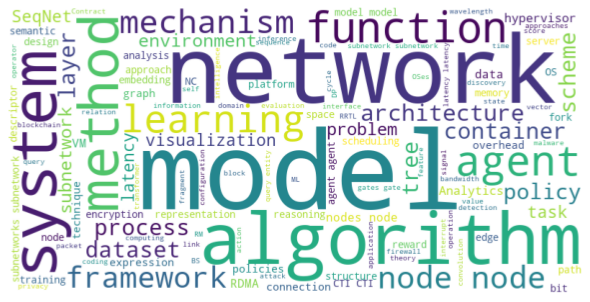

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(ltr)
                    
plt.figure(figsize = (8, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [26]:
# Get a string of all the texts available
tech_trm = physics_trn.groupby(['label'])
cmpt = tech_trm.get_group('TERM')
data_text = [txt for txt in cmpt['token']]
data_text
ltr_p = ""
for i in data_text:
    ltr_p += i + " "    

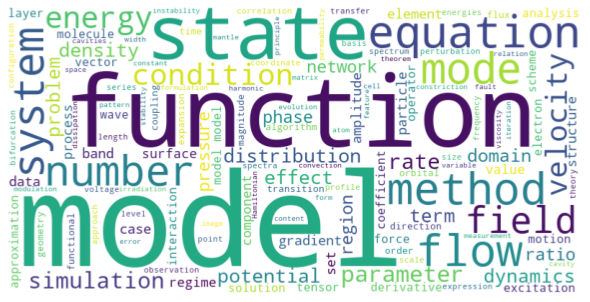

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(ltr_p)
                    
plt.figure(figsize = (8, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [28]:
# Get a string of all the texts available
tech_trm = economics_trn.groupby(['label'])
cmpt = tech_trm.get_group('TERM')
data_text = [txt for txt in cmpt['token']]
data_text
ltr_e = ""
for i in data_text:
    ltr_e += i + " "

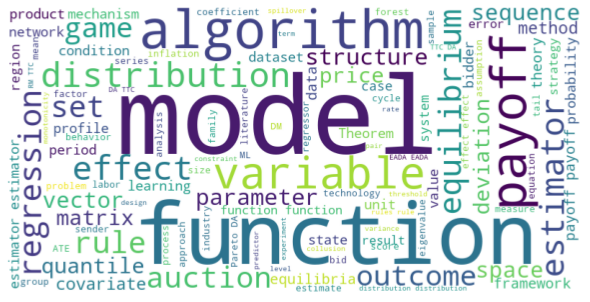

In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(ltr_e)
                    
plt.figure(figsize = (8, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [30]:
grouped = df_val.groupby(['m'])
computer_val = grouped.get_group("cs")
physics_val = grouped.get_group("phys")
economics_val = grouped.get_group("econ")

In [31]:
grouped = df_test.groupby(['m'])
computer_test = grouped.get_group("cs")
physics_test = grouped.get_group("phys")
economics_test = grouped.get_group("econ")

In [32]:
computer_test['token'].isna().sum()

0

In [35]:
computer_test.x.nunique(dropna = True)

30

In [36]:
computer_test.shape

(15457, 5)

In [37]:
physics_test.shape

(13750, 5)

In [38]:
economics_test.shape

(13150, 5)

In [39]:
seq_cmp_trn = [tuple(x) for x in computer_trn.to_numpy()]
print(seq_cmp_trn[1])

('SHAP', 'O', 'cs', '0', '1')


In [40]:
seq_cmp_val = [tuple(x) for x in computer_val.to_numpy()]
print(seq_cmp_val[1])

('~', 'O', 'cs', '0', '1867')


In [41]:
seq_cmp_test = [tuple(x) for x in computer_test.to_numpy()]
print(seq_cmp_test[1])

(',', 'O', 'cs', '0', '1977')


In [42]:
computer_trn["s"] = computer_trn['x'].astype(str) + computer_trn["b"]
computer_trn

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,token,label,m,x,b,s
0,A,O,cs,0,1,01
1,SHAP,O,cs,0,1,01
2,summary,O,cs,0,1,01
3,plot,TERM,cs,0,1,01
4,shows,O,cs,0,1,01
...,...,...,...,...,...,...
163268,measure,O,cs,11,99,1199
163269,of,O,cs,11,99,1199
163270,disclosure,O,cs,11,99,1199
163271,risk,TERM,cs,11,99,1199


In [43]:
computer_val["s"] = computer_val['x'].astype(str) + computer_val["b"]
computer_val

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,token,label,m,x,b,s
0,Section,O,cs,0,1867,01867
1,~,O,cs,0,1867,01867
2,illustrates,O,cs,0,1867,01867
3,the,O,cs,0,1867,01867
4,proposed,O,cs,0,1867,01867
...,...,...,...,...,...,...
14113,file,O,cs,12,1910,121910
14114,descriptor,TERM,cs,12,1910,121910
14115,),O,cs,12,1910,121910
14116,.,O,cs,12,1910,121910


In [44]:
computer_test["s"] = computer_test['x'].astype(str) + computer_test["b"]
computer_test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,token,label,m,x,b,s
0,Next,O,cs,0,1977,01977
1,",",O,cs,0,1977,01977
2,we,O,cs,0,1977,01977
3,analyze,O,cs,0,1977,01977
4,the,O,cs,0,1977,01977
...,...,...,...,...,...,...
15452,',O,cs,12,2019,122019
15453,',O,cs,12,2019,122019
15454,of,O,cs,12,2019,122019
15455,memory,O,cs,12,2019,122019


In [45]:
computer_trn = computer_trn.drop('x', axis=1)
computer_trn = computer_trn.drop('b', axis=1)
computer_trn = computer_trn.drop('m', axis=1)

In [46]:
computer_val = computer_val.drop('x', axis=1)
computer_val = computer_val.drop('b', axis=1)
computer_val = computer_val.drop('m', axis=1)

In [47]:
computer_test = computer_test.drop('x', axis=1)
computer_test = computer_test.drop('b', axis=1)
computer_test = computer_test.drop('m', axis=1)

In [48]:
computer_trn.s.nunique(dropna = True)

6381

In [49]:
computer_val.s.nunique(dropna = True)

554

In [50]:
computer_test.s.nunique(dropna = True)

571

In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [52]:
label_cmp_trn = le.fit_transform(computer_trn['s'])
computer_trn['s'] = label_cmp_trn

In [53]:
label_cmp_val = le.fit_transform(computer_val['s'])
computer_val['s'] = label_cmp_val

In [54]:
label_cmp_tst = le.fit_transform(computer_test['s'])
computer_test['s'] = label_cmp_tst

In [55]:
seq_trn_cmp = [tuple(x) for x in computer_trn.to_numpy()]
#print(seq_trn)

In [56]:
seq_val_cmp = [tuple(x) for x in computer_val.to_numpy()]
#print(seq_val)

In [57]:
seq_tst_cmp = [tuple(x) for x in computer_test.to_numpy()]
#print(seq_val)

In [58]:
computer_trn = computer_trn.dropna() 
computer_trn.s.nunique(dropna = True)

6381

In [59]:
computer_val = computer_val.dropna() 
computer_val.s.nunique(dropna = True)

554

In [60]:
computer_test = computer_test.dropna() 
computer_test.s.nunique(dropna = True)

571

In [61]:
lst_t_cmp = [[] for i in range(6381)]
for i in seq_trn_cmp:
    lst_t_cmp[int(i[2])].append(i)
print(lst_t_cmp[0]) 

[('A', 'O', 0), ('SHAP', 'O', 0), ('summary', 'O', 0), ('plot', 'TERM', 0), ('shows', 'O', 0), ('the', 'O', 0), ('SHAP', 'O', 0), ('value', 'TERM', 0), ('of', 'O', 0), ('features', 'O', 0), ('for', 'O', 0), ('individual', 'O', 0), ('data', 'O', 0), ('points', 'O', 0), ('.', 'O', 0)]


In [62]:
lst_v_cmp = [[] for i in range(6381)]
for i in seq_val_cmp:
    lst_v_cmp[int(i[2])].append(i)
print(lst_v_cmp[0])

[('Section', 'O', 0), ('~', 'O', 0), ('illustrates', 'O', 0), ('the', 'O', 0), ('proposed', 'O', 0), ('tilted', 'O', 0), ('layer', 'O', 0), ('fusion', 'O', 0), ('method', 'TERM', 0), ('.', 'O', 0)]


In [63]:
lst_s_cmp = [[] for i in range(6381)]
for i in seq_tst_cmp:
    lst_s_cmp[int(i[2])].append(i)
print(lst_s_cmp[0])

[('Next', 'O', 0), (',', 'O', 0), ('we', 'O', 0), ('analyze', 'O', 0), ('the', 'O', 0), ('query', 'O', 0), ('frequency', 'O', 0), ('burst', 'O', 0), ('(', 'O', 0), ('cf.', 'O', 0), ('Figure', 'O', 0), (')', 'O', 0), ('.', 'O', 0)]


In [ ]:
# import re
# pattern = r'[!@#$%^&*(),.?":{}|<>]'

def word2features(sent, i):
    word = sent[i][0]
    
    features = {
        'bias': 1.0,
        'word': word,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
#         'word.isspecial()': re.search(pattern, str(word)) != None,
#         'word.isalpha()':word.isalpha(),
#         'word.':word.isidentifier()

    }
    if i > 0:
        word1 = sent[i-1][0]
       
        features.update({
            '-1:word': word,
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]

        features.update({
            '+1:word': word,
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True
                
    return features


def feature_map(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def label_tag(sent):
    return [label for token, label,x in sent]



In [64]:
%%time
train_sents_cmp = list(lst_t_cmp)
val_sents_cmp = list(lst_v_cmp)
test_sent_cmp = list(lst_s_cmp)

CPU times: user 158 µs, sys: 3 µs, total: 161 µs
Wall time: 168 µs


In [ ]:
%%time
X_train_cmp = [feature_map(s) for s in train_sents_cmp]
y_train_cmp = [label_tag(s) for s in train_sents_cmp]

X_val_cmp = [feature_map(s) for s in val_sents_cmp]
y_val_cmp = [label_tag(s) for s in val_sents_cmp]

X_tst_cmp = [feature_map(s) for s in test_sent_cmp]
y_tst_cmp = [label_tag(s) for s in test_sent_cmp]

In [ ]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=False
)
crf.fit(X_train_cmp, y_train_cmp)

In [ ]:
labels_cmp = list(crf.classes_)
print(labels_cmp)

In [ ]:
y_pred_cmp = crf.predict(X_val_cmp)
metrics.flat_f1_score(y_val_cmp, y_pred_cmp, 
                      average='weighted', labels=labels_cmp)

In [ ]:
y_tst_cmp = crf.predict(X_tst_cmp)

In [ ]:
answer = []

In [ ]:
for i in y_tst_cmp:
    for j in i :
        answer.append(j)

In [ ]:
len(answer)

In [ ]:
sorted_labels_cmp = sorted(
    labels_cmp, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_val_cmp, y_pred_cmp, labels=sorted_labels_cmp, digits=3
))

In [ ]:
### Physics

In [ ]:
physics_trn.x.nunique(dropna = True)

In [ ]:
physics_val.x.nunique(dropna = True)

In [ ]:
physics_test.x.nunique(dropna = True)

In [ ]:
seq_phy_trn = [tuple(x) for x in physics_trn.to_numpy()]
print(seq_phy_trn[1])

In [ ]:
seq_phy_val = [tuple(x) for x in physics_val.to_numpy()]
print(seq_phy_val[1])

In [ ]:
seq_phy_test = [tuple(x) for x in physics_test.to_numpy()]
print(seq_phy_test[1])

In [ ]:
physics_trn["s"] = physics_trn['x'].astype(str) + physics_trn["b"]
physics_trn

In [ ]:
physics_val["s"] = physics_val['x'].astype(str) + physics_val["b"]
physics_val

In [ ]:
physics_test["s"] = physics_test['x'].astype(str) + physics_test["b"]
physics_test

In [ ]:
physics_trn = physics_trn.drop('x', axis=1)
physics_trn = physics_trn.drop('b', axis=1)
physics_trn = physics_trn.drop('m', axis=1)

In [ ]:
physics_val = physics_val.drop('x', axis=1)
physics_val = physics_val.drop('b', axis=1)
physics_val = physics_val.drop('m', axis=1)

In [ ]:
physics_test = physics_test.drop('x', axis=1)
physics_test = physics_test.drop('b', axis=1)
physics_test = physics_test.drop('m', axis=1)

In [ ]:
physics_trn.s.nunique(dropna = True)

In [ ]:
physics_val.s.nunique(dropna = True)

In [ ]:
physics_test.s.nunique(dropna = True)

In [ ]:
label_phy_trn = le.fit_transform(physics_trn['s'])
physics_trn['s'] = label_phy_trn

In [ ]:
label_phy_val = le.fit_transform(physics_val['s'])
physics_val['s'] = label_phy_val

In [ ]:
label_phy_tst = le.fit_transform(physics_test['s'])
physics_test['s'] = label_phy_tst

In [ ]:
seq_trn_phy = [tuple(x) for x in physics_trn.to_numpy()]
#print(seq_trn)

In [ ]:
seq_val_phy = [tuple(x) for x in physics_val.to_numpy()]
#print(seq_val)

In [ ]:
seq_tst_phy = [tuple(x) for x in physics_test.to_numpy()]
#print(seq_val)

In [ ]:
physics_trn = physics_trn.dropna() 
physics_trn.s.nunique(dropna = True)

In [ ]:
physics_val = physics_val.dropna() 
physics_val.s.nunique(dropna = True)

In [ ]:
physics_test = physics_test.dropna() 
physics_test.s.nunique(dropna = True)

In [ ]:
lst_t_phy = [[] for i in range(7941)]
for i in seq_trn_phy:
    lst_t_phy[int(i[2])].append(i)
print(lst_t_phy[0]) 

In [ ]:
lst_v_phy = [[] for i in range(7941)]
for i in seq_val_phy:
    lst_v_phy[int(i[2])].append(i)
print(lst_v_phy[0])

In [ ]:
lst_s_phy = [[] for i in range(6381)]
for i in seq_tst_phy:
    lst_s_phy[int(i[2])].append(i)
print(lst_s_phy[0])

In [ ]:
%%time
train_sents_phy = list(lst_t_phy)
val_sents_phy = list(lst_v_phy)
test_sents_phy = list(lst_s_phy)

In [ ]:
%%time
X_train_phy = [sent2features(s) for s in train_sents_phy]
y_train_phy = [sent2labels(s) for s in train_sents_phy]

X_val_phy = [sent2features(s) for s in val_sents_phy]
y_val_phy = [sent2labels(s) for s in val_sents_phy]

X_tst_phy = [sent2features(s) for s in test_sents_phy]
y_tst_phy = [sent2labels(s) for s in test_sents_phy]

In [ ]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.9, 
    c2=0.9, 
    max_iterations=500, 
    all_possible_transitions=True
)
crf.fit(X_train_phy, y_train_phy)

In [ ]:
labels_phy = list(crf.classes_)
print(labels_phy)

In [ ]:
y_pred_phy = crf.predict(X_val_phy)
metrics.flat_f1_score(y_val_phy, y_pred_phy, 
                      average='weighted', labels=labels_phy)

In [ ]:
sorted_labels_phy = sorted(
    labels_phy, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_val_phy, y_pred_phy, labels=sorted_labels_phy, digits=3
))

In [ ]:
y_tst_phy = crf.predict(X_tst_phy)

In [ ]:
for i in y_tst_phy:
    for j in i :
        answer.append(j)

In [ ]:
len(answer)

In [ ]:
### Economics

In [ ]:
economics_trn.x.nunique(dropna = True)

In [ ]:
economics_val.x.nunique(dropna = True)

In [ ]:
economics_test.x.nunique(dropna = True)

In [ ]:
seq_eco_trn = [tuple(x) for x in economics_trn.to_numpy()]
print(seq_eco_trn[1])

In [ ]:
seq_eco_val = [tuple(x) for x in economics_val.to_numpy()]
print(seq_eco_val[1])

In [ ]:
seq_eco_test = [tuple(x) for x in economics_test.to_numpy()]
print(seq_eco_test[1])

In [ ]:
economics_trn["s"] = economics_trn['x'].astype(str) + economics_trn["b"]
economics_trn

In [ ]:
economics_val["s"] = economics_val['x'].astype(str) + economics_val["b"]
economics_val

In [ ]:
economics_test["s"] = economics_test['x'].astype(str) + economics_test["b"]
economics_test

In [ ]:
economics_trn = economics_trn.drop('x', axis=1)
economics_trn = economics_trn.drop('b', axis=1)
economics_trn = economics_trn.drop('m', axis=1)

In [ ]:
economics_val = economics_val.drop('x', axis=1)
economics_val = economics_val.drop('b', axis=1)
economics_val = economics_val.drop('m', axis=1)

In [ ]:
economics_test = economics_test.drop('x', axis=1)
economics_test = economics_test.drop('b', axis=1)
economics_test = economics_test.drop('m', axis=1)

In [ ]:
economics_trn.s.nunique(dropna = True)

In [ ]:
economics_val.s.nunique(dropna = True)

In [ ]:
economics_test.s.nunique(dropna = True)

In [ ]:
label_eco_trn = le.fit_transform(economics_trn['s'])
economics_trn['s'] = label_eco_trn

In [ ]:
label_eco_val = le.fit_transform(economics_val['s'])
economics_val['s'] = label_eco_val

In [ ]:
label_eco_tst = le.fit_transform(economics_test['s'])
economics_test['s'] = label_eco_tst

In [ ]:
seq_trn_eco = [tuple(x) for x in economics_trn.to_numpy()]
#print(seq_trn)

In [ ]:
seq_val_eco = [tuple(x) for x in economics_val.to_numpy()]
#print(seq_val)

In [ ]:
seq_tst_eco = [tuple(x) for x in economics_test.to_numpy()]
#print(seq_val)

In [ ]:
economics_trn = economics_trn.dropna() 
economics_trn.s.nunique(dropna = True)

In [ ]:
economics_val = economics_val.dropna() 
economics_val.s.nunique(dropna = True)

In [ ]:
economics_test = economics_test.dropna() 
economics_test.s.nunique(dropna = True)

In [ ]:
lst_t_eco = [[] for i in range(6576)]
for i in seq_trn_eco:
    lst_t_eco[int(i[2])].append(i)
print(lst_t_eco[0]) 

In [ ]:
lst_v_eco = [[] for i in range(6576)]
for i in seq_val_eco:
    lst_v_eco[int(i[2])].append(i)
print(lst_v_eco[0])

In [ ]:
lst_s_eco = [[] for i in range(6381)]
for i in seq_tst_eco:
    lst_s_eco[int(i[2])].append(i)
print(lst_s_eco[0])

In [ ]:
%%time
train_sents_eco = list(lst_t_eco)
val_sents_eco = list(lst_v_eco)
test_sents_eco = list(lst_s_eco)

In [ ]:
%%time
X_train_eco = [sent2features(s) for s in train_sents_eco]
y_train_eco = [sent2labels(s) for s in train_sents_eco]

X_val_eco = [sent2features(s) for s in val_sents_eco]
y_val_eco = [sent2labels(s) for s in val_sents_eco]

X_tst_eco = [sent2features(s) for s in test_sents_eco]
y_tst_eco = [sent2labels(s) for s in test_sents_eco]

In [ ]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.01, 
    c2=0.01, 
    max_iterations=100, 
    all_possible_transitions=False
)
crf.fit(X_train_eco, y_train_eco)

In [ ]:
labels_eco = list(crf.classes_)
print(labels_eco)

In [ ]:
y_pred_eco = crf.predict(X_val_eco)
metrics.flat_f1_score(y_val_eco, y_pred_eco, 
                      average='weighted', labels=labels_eco)

In [ ]:
sorted_labels_eco = sorted(
    labels_eco, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_val_eco, y_pred_eco, labels=sorted_labels_eco, digits=3
))

In [ ]:
y_tst_eco = crf.predict(X_tst_eco)

In [ ]:
for i in y_tst_eco:
    for j in i :
        answer.append(j)

In [ ]:
len(answer)

In [ ]:
submission_df = pd.read_csv("/kaggle/input/jargon-detection/test_no_labels.csv",sep=",",encoding="latin1")

In [ ]:
submission_df['label'] = pd.DataFrame(answer)

In [ ]:
submission_df = submission_df.drop(['token'], axis=1)

In [ ]:
submission_df.to_csv("/kaggle/working/edited.csv", index=False)